In [2]:
import biosignalsnotebooks as bsnb
from numpy import linspace, diff, zeros_like, arange, array
from scipy import signal
from scipy.signal import correlate
import scipy as sp
from scipy.signal import find_peaks
import math
from scipy import signal as scisig
import neurokit2 as nk
import statistics

import biosignalsnotebooks as bsnb
from scipy.fft import rfft, rfftfreq
from scipy.fft import irfft

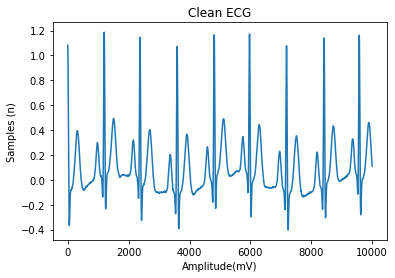

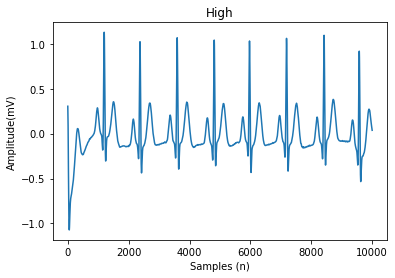

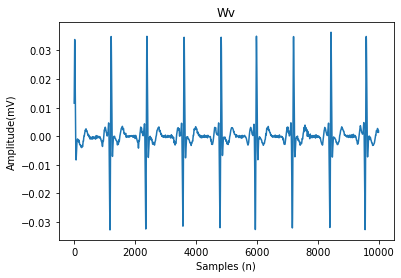

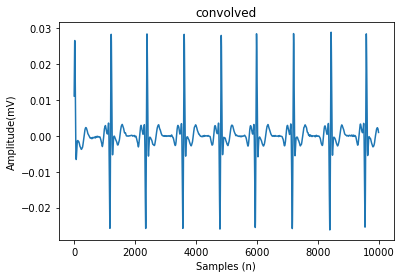

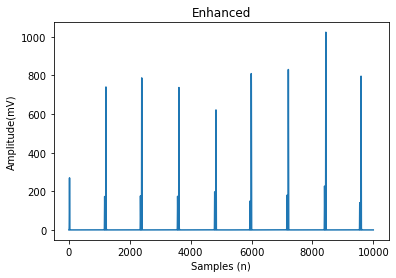

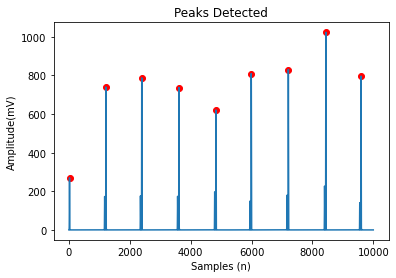

In [2]:
%run "3.0 - Functions_peakdetection.ipynb"

In [82]:
def _hrvreading(peaks):
    hrv_values_c = []
   # peaks = peaks[['x_values']].tolist()
    df = pd.DataFrame(columns=['R-R Interval', 'x_value'])
    for index, value in enumerate(peaks['x_values']): #The HRV values are calculated inside this for loop. The for loop ends if the index values get bigger than the array itself.
        print(index)
        if index+1 == len(peaks) :
            break
        diff = peaks.loc[index+1]['x_values']-peaks.loc[index]['x_values']
        #if diff > 100:
        hrv_values_c.append(diff)
        print(df)
        df.loc[index] = [diff, peaks['x_values']]
        print(df)
        
    
    print(df)
   '''hrv_values_c_m = np.mean(hrv_values_c) #The mean value of the HRV signal is calculated and subtracted from the original HRV signal.
    hrv_values_c = hrv_values_c - hrv_values_c_m
 
    hrv_data = []
    n = 0
    while n < len(hrv_values_c): #To account for outliers and peaks values which may be due to an error in reading, a sliding window is performed.
        i = 0
        window_values = []
        while i < 500: # The sliding window has a value of 200
            if n >= len(hrv_values_c):
                break
            window_values.append(hrv_values_c[n])
            n += 1
            i += 1
            
        if len(window_values) > 1:

            mean = np.mean(window_values) # The values that are found to be two standard deviations from the mean are changed by the mean value of the window.
            std = statistics.stdev(window_values)
            for index, value in enumerate(window_values):
                if value > (mean+2*std) or value < -(mean+2*std):
                    window_values[index] = mean

            hrv_data = hrv_data + window_values
            n += 1
    #print(hrv_data)
    #time = bsnb.generate_time(hrv_data[0:100]) #The data is then plotted to reconstruct the signal.
    plt.plot(hrv_data)
    plt.xlabel('Interval number')
    plt.ylabel('R-R Interval')
    #plt.show()
     '''


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 18)

In [78]:
#Function definition for the Fast Fourier Transform and plotting the PSD of the signal.
def _fft(df,rate):
    time = df['x_value']
    time_len = len(time)
    
    hrv_signal = df['R-R Interval']

    # Number of samples in normalized_tone
    N = int(len(hrv_signal.index))

    hrv_values_m = np.mean(hrv_signal) # We calculate the mean and we subtract it from every value to normalise the signal.
    hrv_fft = hrv_signal - hrv_values_m

    xf = rfftfreq(N, 1 / rate)
    yf = rfft(hrv_fft)
    new_signal = irfft(yf)

    plt.plot(xf,np.abs(yf))
    plt.xlabel('Frequency(mHz)')
    plt.ylabel('Power')
    #plt.axvline(x=4, color='r')
    plt.axvline(x=15, color='r')
    plt.axvline(x=40, color='b')
    #plt.title('PSD Healthy Patient')
    #plt.show()
    
    #HF - 0.15-0.4, LF - 0.04-0.15


In [79]:
#Function definition for computing the Inverse Fast Fourier Transform and plotting the signal.
def _ifft(frq_signal):
    new_signal = irfft(frq_signal)
    time = bsnb.generate_time(new_signal)
    
    plt.plot(time,new_signal)
    plt.xlabel('Time(s)')
    plt.ylabel('R-R Interval')
    plt.title('HRV Healthy Patient')
    plt.show()

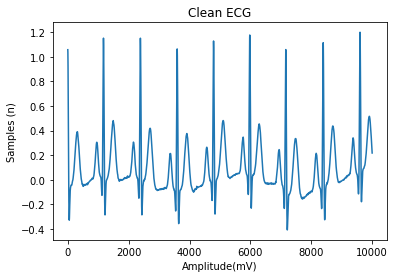

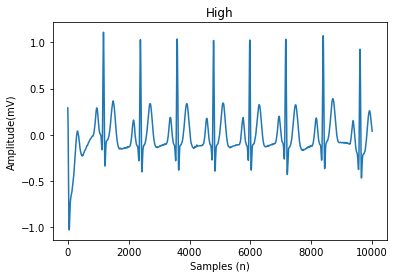

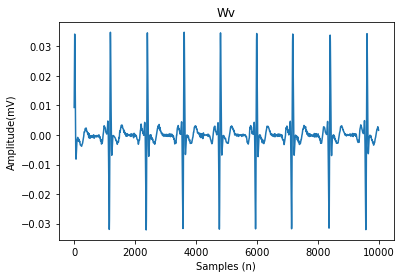

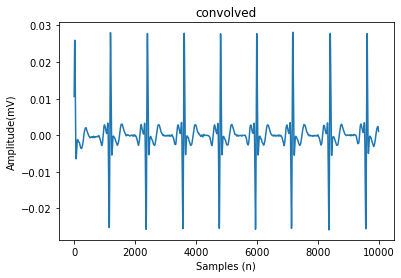

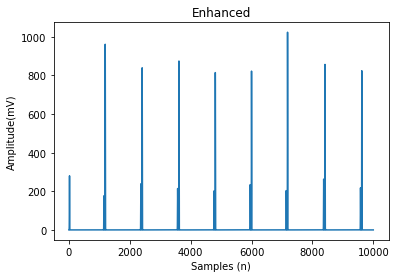

[[  20]
 [1192]
 [2406]
 [3614]
 [4808]
 [5998]
 [7181]
 [8410]
 [9620]]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

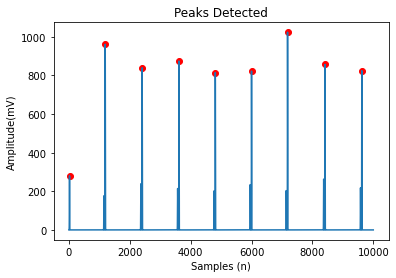

In [84]:
#Testing the functions with synthetic data that has already successfully passed the peak detection
# We generate three different synthethic ECG signals. Library: neurokit2

ecg50 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=50) # No noise, HR:50
ecg80 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=80) # No noise, HR:80
ecg100 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=100) # No noise, HR:100

#Plotting the signals 
plt.plot(ecg50)
plt.xlabel("Amplitude(mV)")
plt.ylabel("Samples (n)")
plt.title("Clean ECG")
plt.show()

#Filtering the signals and plotting them in each step of the process
filtered50 = _filtering(ecg50,1000)
plt.plot(filtered50)
plt.ylabel("Amplitude(mV)")
plt.xlabel("Samples (n)")
plt.title("Enhanced")
plt.show()

#Detecting the peaks and plotting them
peaks = _peakdetection(filtered50)
plt.plot(filtered50)
plt.scatter(peaks['x_values'],peaks['y_values'], marker='o', color='r')
plt.ylabel("Amplitude(mV)")
plt.xlabel("Samples (n)")
plt.title("Peaks Detected")

#Calculate the HRV
peaks = peaks[['x_values']].to_numpy()

print(peaks)
_hrvreading(peaks)
#peaks = peaks[['x_values']].to_numpy()
#p=np.array([1,2,3])
#print(peaks, np.shape(peaks), type(peaks[1,0]), type(peaks), p, np.shape()
